In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.interpolate
from classy import Class

import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 15})

## Best fitting with CLASS and scipy.optimize

In [2]:
home = os.getcwd()
print('Current working directory:', home)

Current working directory: /mnt/c/Users/darby/OneDrive/Desktop/cosmo_dep_feedback


In [3]:
# Fixed cosmological parameters
Ω_b = 0.049
h = 0.6711
n_s = 0.9624
ω = -1
M_ν = 0.0 #eV
Ω_k = 0

In [4]:
## Load in IllustrisTNG simulation parameters
lhc_TNG = np.loadtxt(home+'/latin_hypercube_params_IllustrisTNG.txt')

# Ω_m, σ_8, A_SN1, A_SN2, A_AGN1, A_AGN2
Ω_m, σ_8, A1, A2, A3, A4 = lhc_TNG[:,0], lhc_TNG[:,1], lhc_TNG[:,2], lhc_TNG[:,2], lhc_TNG[:,4], lhc_TNG[:,5]

In [24]:
## Load in data 
# redshift, z = 0.00
k = np.load(home+'/Pk/IllustrisTNG_k_m_z=0.00.npy')
Pk = np.load(home+'/Pk/IllustrisTNG_Pk_m_z=0.00.npy')
Pk0 = Pk[0]

In [66]:
# Paco said k values less than 30 should be good so I will cut out those values.
index = np.where(k>30)[0]
ks = k[0:index[0]]
Pks0 = Pk0[0:index[0]]

ks.shape, Pks0.shape

((118,), (118,))

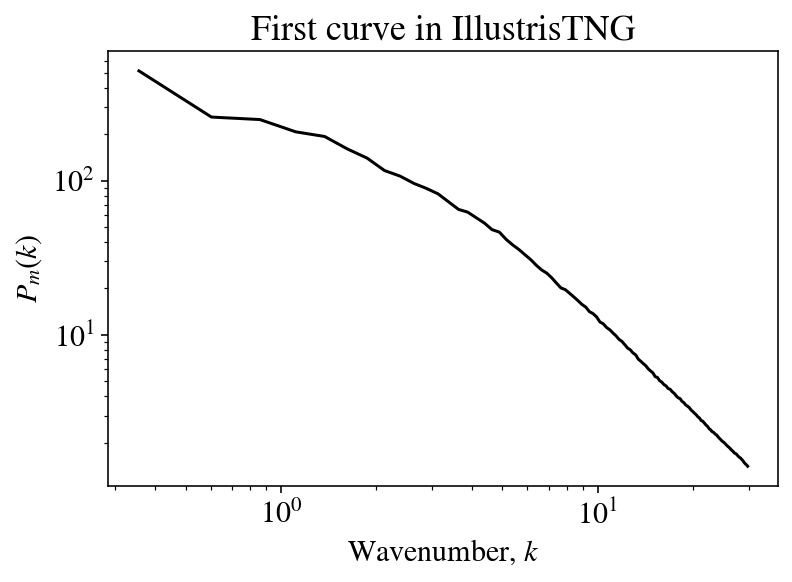

In [67]:
plt.figure()
plt.title('First curve in IllustrisTNG')
plt.loglog(ks, Pks0, 'k')
plt.xlabel('Wavenumber, $k$')
plt.ylabel('$P_m(k)$')
plt.show()

In [68]:
# Interpolating k values
# interp = scipy.interpolate.interp1d(k, Pk0)

# Curve fit model using CLASS
def class_model(x_data, eta, c):
    model = Class()
    model.set({'output':'mPk',
               'non_linear':'hmcode',
#                'feedback model': 'owls_agn',
               'h': h,
               'n_s': n_s,
               'Omega_b': Ω_b,
               'Omega_k': Ω_k,
               'eta_0': eta,
               'c_min': c,
               'P_k_max_h/Mpc': 100,  # This value must agree with max value in logspace for k_model
               'lensing':'no',
               'z_pk':0 
              })
    model.compute()
    
    k_model = np.linspace(min(x_data), max(x_data), len(x_data))
    
    Pk_model = [] 
#     h = model.h() 
    for k in k_model:
        Pk = model.pk(k*h, 0)*h**3
        Pk_model.append(Pk) 
    Pk_model = np.array(Pk_model)
    
    return Pk_model

In [69]:
guesses = np.array([0.76, 2.32]) # 'owls_agn' params
opt, cov = scipy.optimize.curve_fit(class_model, ks, Pks0, guesses) 
opt

array([   6.41119608, 1196.80609983])

In [101]:
guesses2 = np.array([0.001, 1]) # changing OOM
opt2, cov2 = scipy.optimize.curve_fit(class_model, ks, Pks0, guesses) 
opt2

array([   6.41119608, 1196.80609983])

NOTE: Changing the guesses by many OOM did not help scipy.optimize come out of it's local minimum. Run MCMC to see if that helps.

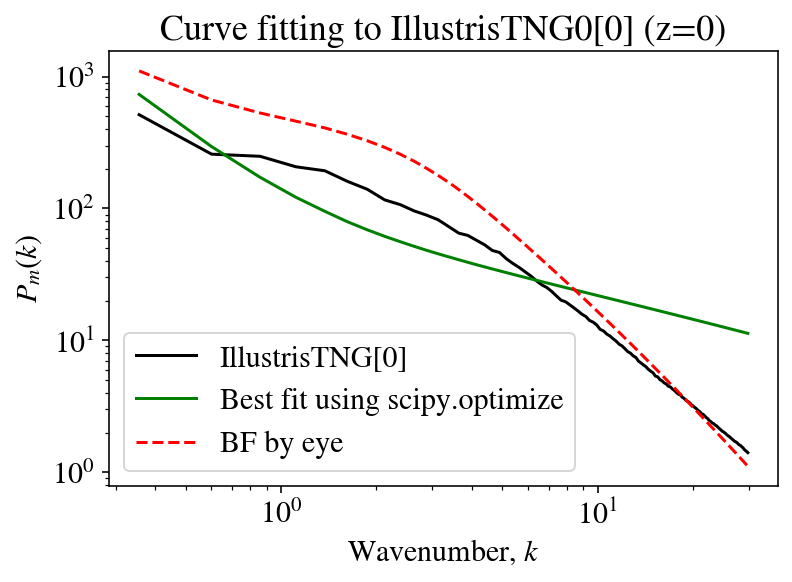

In [100]:
plt.figure()
plt.loglog(ks, Pks0, 'k', label='IllustrisTNG[0]')
plt.loglog(ks, class_model(ks, *opt), 'g', label='Best fit using scipy.optimize')
plt.loglog(ks, class_model(ks, 0.005, 3), 'r--', label='BF by eye')
# plt.loglog(ks, class_model(ks, 0.3, 3), 'b:', label='BF by eye II')
plt.legend()
plt.title('Curve fitting to IllustrisTNG0[0] (z=0)')
plt.xlabel('Wavenumber, $k$')
plt.ylabel('$P_m(k)$')
plt.show()

Because I can find a better fit by curve fitting by eye, I am assuming that I am once again getting stuck in some local minimum. So I will need to use MCMC or something similar to find the global minimum.

## Interpolation scratch work

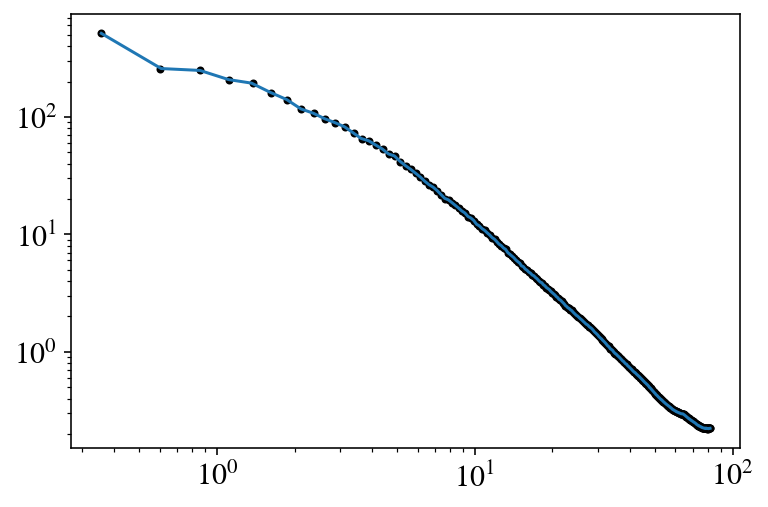

In [121]:
plt.figure()
plt.loglog(k_cut, Pk0_cut, 'k.')

xnew = np.linspace(min(k_cut), max(k_cut), len(k_cut))
f_lin = scipy.interpolate.interp1d(k_cut, Pk0_cut, fill_value='extrapolate', kind='linear')
plt.loglog(xnew, f_lin(xnew))

# plt.loglog(k_cut, Pk0_cut)
plt.show()

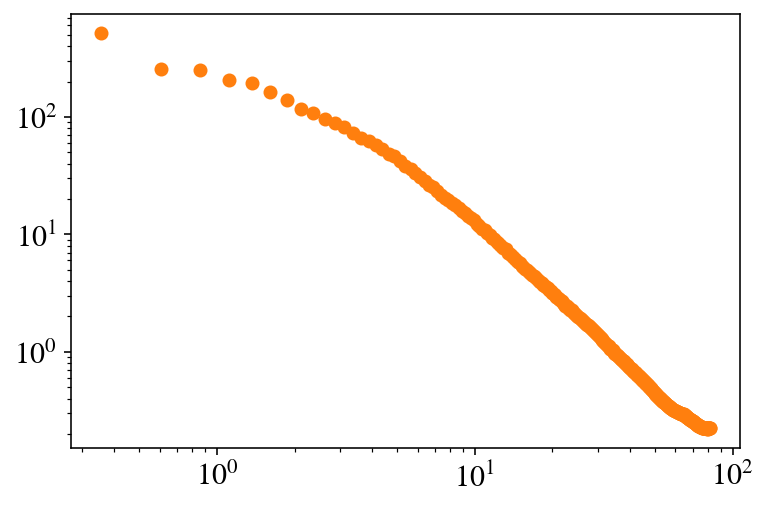

In [129]:
x = k_cut
y = Pk0_cut
# My x and y are the Pk and k data from IllustrisTNG
interp = scipy.interpolate.interp1d(x, y, fill_value="extrapolate") # Interpolator

xnew = np.linspace(min(x), max(x), len(k_cut))
ynew = interp(xnew)   # use interpolation function returned by `interp1d`
plt.loglog(x, y, '.') #
plt.loglog(xnew, ynew, 'o')
plt.show()
# orange is model --> CLASS Pk and k

## Trying MCMC with CLASS

In [76]:
import emcee
import corner

In [89]:
# Fixed cosmological parameters
Ω_b = 0.049
h = 0.6711
n_s = 0.9624
ω = -1
M_ν = 0.0 #eV
Ω_k = 0

In [90]:
Pk0_cut_err = 0.10*Pk0_cut # fake 10% error for now

In [91]:
# Log-likelihood function:
def log_likelihood(theta, x, y, yerr):
    eta, c = theta
    model = Class()
    model.set({'output':'mPk',
               'non_linear':'hmcode',
               'h': h,
               'n_s': n_s,
               'Omega_b': Ω_b,
               'Omega_k': Ω_k,
               'eta_0': eta,
               'c_min': c,
               'P_k_max_h/Mpc': 100,  # This value must agree with max value in logspace for k_model
               'lensing':'no',
               'z_pk':0 
              })
    model.compute()
    
    k_model = np.logspace(-1, 2, len(x))
    Pk_model = [] 
#     h = model.h() 
    for k in k_model:
        Pk = model.pk(k*h, 0)*h**3
        Pk_model.append(Pk) 
    Pk_model = np.array(Pk_model)
    
    sigma2 = yerr**2
    return -0.5 * np.sum((y - Pk_model)**2 / sigma2 + np.log(sigma2))

In [92]:
nll = lambda *args: -log_likelihood(*args)
# maximizing the likelihood is the same as minimizing the negative of the liklihood
initial = np.array([1, 0.1])
soln = scipy.optimize.minimize(nll, initial, args=(k_cut, Pk0_cut, Pk0_cut_err))
eta_ml, c_ml = soln.x # maximum likelihood values
print('Maximum likelihood values:', soln.x)

Maximum likelihood values: [1011.52871978 -220.0910173 ]


In [99]:
# Log priors
def log_prior(theta): # sets up priors on theta
    eta, c = theta
    if -20 < eta < 5000 and -1000 < c < 20:
        return 0.0
    return -np.inf 

In [100]:
# Log probability
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta) 
    if not np.isfinite(lp): 
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [107]:
pos = soln.x + 10 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
# pos
sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim,
                                log_probability,
                                args=(k_cut, Pk0_cut, Pk0_cut_err))

sampler.run_mcmc(pos, 50, progress=True)

ValueError: Probability function returned NaN

In [97]:
samples = sampler.get_chain()
# np.save('50_chain_CLASS_MCMC_test_run.npy', samples)